<a href="https://colab.research.google.com/github/aravind309/Tensorflow-AI/blob/master/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/gdrive/MyDrive/DSC/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/content/gdrive/MyDrive/DSC/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2021-02-19 00:00:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.217.8.16, 172.217.13.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/gdrive/MyDrive/DSC/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/gdrive/MyD 100%[===================>]  83.84M  75.7MB/s    in 1.1s    

2021-02-19 00:00:44 (75.7 MB/s) - ‘/content/gdrive/MyDrive/DSC/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [4]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])


In [5]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /content/gdrive/MyDrive/DSC/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//content/gdrive/MyDrive/DSC/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('//content/gdrive/MyDrive/DSC/')
zip_ref.close()

# Define our example directories and files
base_dir = '/content/gdrive/MyDrive/DSC/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2021-02-19 00:01:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 142.250.73.240, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/gdrive/MyDrive/DSC/cats_and_dogs_filtered.zip’

/content/gdrive/MyD 100%[===================>]  65.43M  75.4MB/s    in 0.9s    

2021-02-19 00:01:46 (75.4 MB/s) - ‘/content/gdrive/MyDrive/DSC/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 31s - loss: 0.3337 - accuracy: 0.8620 - val_loss: 0.1306 - val_accuracy: 0.9510
Epoch 2/20
100/100 - 21s - loss: 0.2232 - accuracy: 0.9130 - val_loss: 0.1049 - val_accuracy: 0.9580
Epoch 3/20
100/100 - 21s - loss: 0.1843 - accuracy: 0.9280 - val_loss: 0.1125 - val_accuracy: 0.9600
Epoch 4/20
100/100 - 21s - loss: 0.1976 - accuracy: 0.9310 - val_loss: 0.1859 - val_accuracy: 0.9420
Epoch 5/20
100/100 - 21s - loss: 0.1951 - accuracy: 0.9340 - val_loss: 0.1091 - val_accuracy: 0.9670
Epoch 6/20
100/100 - 21s - loss: 0.1808 - accuracy: 0.9350 - val_loss: 0.1316 - val_accuracy: 0.9680
Epoch 7/20
100/100 - 21s - loss: 0.1798 - accuracy: 0.9370 - val_loss: 0.1259 - val_accuracy: 0.9580
Epoch 8/20
100/100 - 20s - loss: 0.1682 - accuracy: 0.9400 - val_loss: 0.2612 - val_accuracy: 0.9390
Epoch 9/20
100/100 - 21s - loss: 0.1571 - accuracy: 0.9415 - val_loss: 0.2292 - val_accuracy: 0.9360
Epoch 10/20
100/100 - 21s - loss: 0.1448 - accuracy: 0.9495 - val_loss: 0.1372 - val_accura

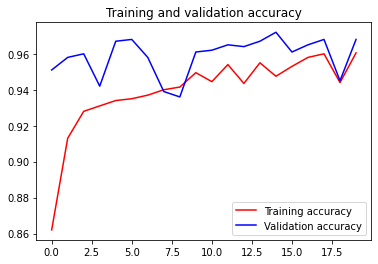

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________